In [1]:
!pip install pyspark
!pip install findspark

# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 6.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fc8740e851f53fbedc8c8fb805401a434c75930dd568f60bed7d979b18f21a2e
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# (1) Import the required Python dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [3]:
# (2) Instantiate a Spark Context
sqlContext = SQLContext(spark)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
# (3) Load the Breast Cancer dataset (data/breast-cancer-data/dataR2.csv) into a Spark DataFrame
breast_cancer_df = sqlContext.read.format('com.databricks.spark.csv').options(header = 'true', inferschema = 'true').load('/content/dataR2.csv')
breast_cancer_df = breast_cancer_df.withColumnRenamed('MCP.1', 'MCP_1')
indexer = StringIndexer(inputCol = "Classification", outputCol = "label").fit(breast_cancer_df)
breast_cancer_df = indexer.transform(breast_cancer_df)
breast_cancer_df.show(10)

+---+-----------+-------+-------+-----------+-------+-----------+--------+--------+--------------+-----+
|Age|        BMI|Glucose|Insulin|       HOMA| Leptin|Adiponectin|Resistin|   MCP_1|Classification|label|
+---+-----------+-------+-------+-----------+-------+-----------+--------+--------+--------------+-----+
| 48|       23.5|     70|  2.707|0.467408667| 8.8071|     9.7024| 7.99585| 417.114|             1|  1.0|
| 83|20.69049454|     92|  3.115|0.706897333| 8.8438|   5.429285| 4.06405| 468.786|             1|  1.0|
| 82|23.12467037|     91|  4.498|1.009651067|17.9393|   22.43204| 9.27715| 554.697|             1|  1.0|
| 68|21.36752137|     77|  3.226|0.612724933| 9.8827|    7.16956|  12.766|  928.22|             1|  1.0|
| 86|21.11111111|     92|  3.549|  0.8053864| 6.6994|    4.81924|10.57635|  773.92|             1|  1.0|
| 49|22.85445769|     92|  3.226|0.732086933| 6.8317|   13.67975| 10.3176|  530.41|             1|  1.0|
| 89|       22.7|     77|   4.69|0.890787333|  6.964|  

In [5]:
# (4) Calculate standard statistical descriptive analytics on the raw Breast Cancer Spark DataFrame
breast_cancer_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,116,57.30172413793103,16.112765572452282,24,89
BMI,116,27.582110827413807,5.020135768568436,18.37,38.57875854
Glucose,116,97.79310344827586,22.525161676350454,60,201
Insulin,116,10.012086206896548,10.067767636993997,2.432,58.46
HOMA,116,2.6949875643965515,3.6420431918896914,0.467408667,25.05034187
Leptin,116,26.61508017241379,19.18329407226946,4.311,90.28
Adiponectin,116,10.180873965517243,6.843341448787964,1.65602,38.04
Resistin,116,14.725965862068964,12.39064567765953,3.21,82.1
MCP_1,116,534.6470000000003,345.91266325599037,45.843,1698.44


In [6]:
# (5) Generate Input Feature Vectors from the Raw Spark DataFrame
feature_columns = ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP_1']
label_column = 'label'
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
breast_cancer_features_df = vector_assembler.transform(breast_cancer_df).select(['features', label_column])
breast_cancer_features_df.head(10)

[Row(features=DenseVector([48.0, 23.5, 70.0, 2.707, 0.4674, 8.8071, 9.7024, 7.9958, 417.114]), label=1.0),
 Row(features=DenseVector([83.0, 20.6905, 92.0, 3.115, 0.7069, 8.8438, 5.4293, 4.064, 468.786]), label=1.0),
 Row(features=DenseVector([82.0, 23.1247, 91.0, 4.498, 1.0097, 17.9393, 22.432, 9.2772, 554.697]), label=1.0),
 Row(features=DenseVector([68.0, 21.3675, 77.0, 3.226, 0.6127, 9.8827, 7.1696, 12.766, 928.22]), label=1.0),
 Row(features=DenseVector([86.0, 21.1111, 92.0, 3.549, 0.8054, 6.6994, 4.8192, 10.5764, 773.92]), label=1.0),
 Row(features=DenseVector([49.0, 22.8545, 92.0, 3.226, 0.7321, 6.8317, 13.6798, 10.3176, 530.41]), label=1.0),
 Row(features=DenseVector([89.0, 22.7, 77.0, 4.69, 0.8908, 6.964, 5.5899, 12.9361, 1256.083]), label=1.0),
 Row(features=DenseVector([76.0, 23.8, 118.0, 6.47, 1.8832, 4.311, 13.2513, 5.1042, 280.694]), label=1.0),
 Row(features=DenseVector([73.0, 22.0, 97.0, 3.35, 0.8015, 4.47, 10.3587, 6.2844, 136.855]), label=1.0),
 Row(features=DenseVecto

In [7]:
# (6) Split the Raw DataFrame into a Training DataFrame and a Test DataFrame
train_df, test_df = breast_cancer_features_df.randomSplit([0.75, 0.25], seed=12345)
train_df.count(), test_df.count()

(103, 13)

In [8]:
# (7) Train a Logistic Regression Model on the Training DataFrame
logistic_regression = LogisticRegression(featuresCol = 'features', labelCol = label_column)
logistic_regression_model = logistic_regression.fit(train_df)

In [9]:
# (8) Output Logistic Regression Model Summary Statistics to evaluate the Training Model
print("Model Coefficients: " + str(logistic_regression_model.coefficientMatrix))
print("Intercept: " + str(logistic_regression_model.interceptVector))

Model Coefficients: DenseMatrix([[ 0.02052757,  0.19301768, -0.10805388, -0.22254947,  0.68051123,
               0.00305008,  0.00615943, -0.05032843, -0.00105035]])
Intercept: [5.0280469322433206]


In [10]:
# (9) Apply the Trained Logistic Regression Model to the Test DataFrame to make predictions
test_logistic_regression_predictions_df = logistic_regression_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_logistic_regression_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show()

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+--------------------+----------+-----+--------------------+
|         probability|       rawPrediction|prediction|label|            features|
+--------------------+--------------------+----------+-----+--------------------+
|[0.37086488683271...|[-0.5285082300994...|       1.0|  1.0|[34.0,21.47,78.0,...|
|[0.55715197381954...|[0.22961139103252...|       0.0|  1.0|[44.0,20.76,86.0,...|
|[0.97646269593323...|[3.72534997813025...|       0.0|  0.0|[44.0,24.74,106.0...|
|[0.96286084213833...|[3.25523701585897...|       0.0|  0.0|[45.0,21.30394858...|
|[0.18387877472320...|[-1.4902861968612...|       1.0|  0.0|[46.0,33.18,92.0,...|
|[0.40272247959029...|[-0.3941341752116...|       1.0|  1.0|[50.0,38.57875854...|
|[0.83872206535738...|[1.64875020387755...|       0.0|  0.0|[51.0,22.89281998...|
|[0.79224512586494...|[1.33851195128227...|       0.0|  0.0|[64.0,22.22222222...|
|[0.38241212581809...|[-0.4793224742951...|       

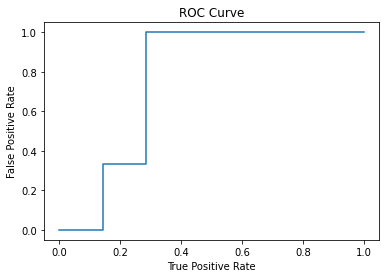

Area Under ROC Curve on Test Data = 0.761905


In [11]:
# (10) Evaluate the performance of our Logistic Regression Model on the Test DataFrame using Area under a ROC curve
test_summary = logistic_regression_model.evaluate(test_df)
roc = test_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
evaluator_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_roc_area.evaluate(test_logistic_regression_predictions_df))

In [12]:
# (11) Generate a Confusion/Classification Matrix
N = test_logistic_regression_predictions_df.count()
true_positives = test_logistic_regression_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 1.0 ).count()
true_negatives = test_logistic_regression_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 0.0 ).count()
false_positives = test_logistic_regression_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 0.0 ).count()
false_negatives = test_logistic_regression_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 1.0 ).count()
print("N = %g" % N)
print("Overall Accuracy = %g" % ((true_negatives + true_positives)/N))
print("Overall Error Rate = %g" % ((false_negatives + false_positives)/N))
print("Sensitivity = %g" % (true_positives / (true_positives + false_negatives)))
print("Specificity = %g" % (true_negatives / (true_negatives + false_positives)))

N = 13
Overall Accuracy = 0.615385
Overall Error Rate = 0.384615
Sensitivity = 0.5
Specificity = 0.714286


In [ ]:
# (13) Stop the Spark Context
spark.stop()